# Modeling SNAP Policy Generosity Across U.S States

##### By: By: Shawn Ding, Grace George, Razan Habboub, Arnav Jain, Aeon Levy
Click [Here](https://github.com/aeonlevy/ds6021_Project_Materials) to acess our Project GitHub

# Ⅰ. Introduction & Project Overview

SNAP is one of the main safety-net programs in the US, but states differ substantially by how generous their SNAP benefits.

Our project lookas at SNAP (Supplemental Nutrition Assistance Program) across the  U.S. 

We want to construct a state-level dataset combining SNAP benefits, social inequality, income, food price indices, demographics, and policy variables to better understand the concept of **SNAP Policy Generosity**. 

   ### ✶ Reseach Question(s) and Motavations  ✶

We want to understand what factors drive differences in SNAP allocation and how these patterns could inform policymakers.

- Goal: Highlight associations in SNAP generosity across states.

- Motivation: Support future empirical research on social safety nets and guide evidence-based policy decisions.

Scope & Limitations

- The analysis is cross-sectional and descriptive; we do not infer causality.

- Focus is on patterns and associations, not on predicting individual outcomes or making policy recommendations directly.


**We focus on three main questions...**


1. How can we construct a consistent, state-level measure of SNAP generosity?

    -We use participants per 1,000 residents and per-person benefit levels as core indicators of program reach and generosity.

2. How do economic, demographic, and policy environments relate to SNAP generosity?

    -We combine poverty, income, grocery cost indices, racial composition, minimum wage tier, political trifecta status, etc...into a single modeling dataset.

3. Can we predict whether states fall into Low, Moderate, or High SNAP generosity classes?

    -We use several predictive methods and models to assess how well observable features classify.


*Note ~ Our analysis is cross-sectional and descriptive, so we do not claim causality. Our aim is to highlight patterns and associations*

---------------------------------------------------------------------------------

# Ⅱ. Engineering and Cleaning the Data

   ### ✶ Selecting the Data ✶

We build a state-level dataset by merging the following sources:

- **ACS 2024 – Race (Table B02001):**  
  Total population and race counts, used to compute race shares by state.

- **ACS 2024 – Median Household Income (Table B19013):**  
  State-level median household income.

- **ACS 2024 – Poverty (Table S1701):**  
  Share of the population below the poverty line.

- **USDA SNAP Benefits & Participants (May 2025):**  
  State-level total SNAP benefits and number of participants.

- **BLS Regional Price Parities – Food-at-Home (RPP):**  
  State-level index of grocery cost (food-at-home price parity).

- **USDA SNAP Regions:**  
  Assignment of states to SNAP regional offices.

- **State Trifecta Control (2024):**  
  Whether each state is under Democratic, Republican, or divided trifecta control.

- **State Minimum Wage (2025):**  
  State-level minimum wage and a derived wage tier (low / medium / high).

- **Rural–Urban Continuum Codes (RUCC 2023):**  
  County-level RUCC codes aggregated to median RUCC by state and collapsed into 
  an urban / mixed / rural category.



### ✶ Our Derived Variables ✶
**The Key variables used in our modeling...**


Target Variable(Categorical):
  - `snap_policy_class` (Low, Moderate, High) based on per-person SNAP benefits.


Categorical Predictors:
  - `min_wage_tier` (low / medium / high)
  - `trifecta_2024` (Democratic / Republican / Divided)
  - `rural_urban_category` (urban / mixed / rural)
  - `usda_snap_region` (USDA SNAP region labels)


Core Numeric Predictors:
  - `benefits_per_person`
  - `participants_per_1000`
  - `poverty_rate`
  - `grocery_cost_index`
  - `median_household_income`

Additional Demographic Predictors (Numerical):
  - `white_pct`, 
  -`black_pct`, 
  -`native_pct`, 
  -`asian_pct`, `pacific_pct`, 
  -`two_plus_pct`


*Note ~ We treat race as numeric percentage variables, not as a single majority-race label, to preserve more information for modeling*



From these raw sources, we constructed...

- **benefits_per_person** – May 2025 SNAP benefits divided by participants  
- **participants_per_1000** – SNAP participants per 1,000 residents  
- **grocery_cost_index** – 2023 food-at-home RPP value for each state  
- **poverty_rate** – ACS poverty share (proportion)  
- **median_household_income** – ACS median household income (USD)  
- **Race shares** – `white_pct`, `black_pct`, `native_pct`, `asian_pct`, 
  `pacific_pct`, `two_plus_pct`  
- **Policy and geography** – `min_wage_tier`, `trifecta_2024`, 
  `rural_urban_category`, `usda_snap_region`




### ✶ Final Outcome: SNAP Policy Class ✶

We create a categorical target variable, **`snap_policy_class`**, that groups states 
into three SNAP generosity classes based on **SNAP participants per 1,000 residents**:

- **Low:** Below the 33rd percentile of `participants_per_1000`  
- **Moderate:** Between the 33rd and 66th percentiles  
- **High:** At or above the 66th percentile  

The final modeling dataset has **51 rows (50 states + DC)** and a combined set of economic, demographic, and policy features for each state.

In [ ]:
# ============================================
# Imports and directory setup
# ============================================


from pathlib import Path

import numpy as np
import pandas as pd
from pandas.errors import ParserError

# For modeling and visualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# ============================================
# Imports and directory setup
# ============================================

# Base project directory = folder where this notebook lives
PROJECT_DIR = Path.cwd()
RAW_DIR = PROJECT_DIR / "raw"
PROCESSED_DIR = PROJECT_DIR / "processed"

print("Project directory:", PROJECT_DIR)
print("Raw data directory:", RAW_DIR)
print("Processed data directory:", PROCESSED_DIR)
print("\nDirectory existence check:")
print("RAW_DIR exists:", RAW_DIR.exists())
print("PROCESSED_DIR exists:", PROCESSED_DIR.exists())


Project directory: /Users/aeonlevy/Desktop/UVA_MATS/Engineering/Project_Mats/DS_6021_Final_Project
Raw data directory: /Users/aeonlevy/Desktop/UVA_MATS/Engineering/Project_Mats/DS_6021_Final_Project/raw
Processed data directory: /Users/aeonlevy/Desktop/UVA_MATS/Engineering/Project_Mats/DS_6021_Final_Project/processed

Directory existence check:
RAW_DIR exists: True
PROCESSED_DIR exists: True


In [3]:
# ============================================
# Load raw CSV data robustly
# ============================================

data_paths = {
    "acs_race":       RAW_DIR / "ACSDT1Y2024.B02001-Data.csv",
    "acs_income":     RAW_DIR / "ACSDT1Y2024.B19013-Data.csv",
    "acs_poverty":    RAW_DIR / "ACSST1Y2024.S1701-Data.csv",
    "snap_benefits":  RAW_DIR / "snap-benefits-8.csv",
    "snap_persons":   RAW_DIR / "snap-persons-8.csv",
    "state_trifecta": RAW_DIR / "state_trifecta_2024.csv",
    "snap_regions":   RAW_DIR / "usda_snap_regions.csv",
    "rpp":            RAW_DIR / "SARPP_STATE_2008_2023.csv",
    "rural_raw":      RAW_DIR / "Ruralurbancontinuumcodes2023.csv",
    "state_min_wage": RAW_DIR / "state_minimum_wage_2025.csv",
}

dfs = {}

for name, path in data_paths.items():
    try:
        df = pd.read_csv(path, dtype=str, encoding_errors="replace")
        sep_used = ","
    except ParserError:
        try:
            df = pd.read_csv(path, dtype=str, sep="\t", encoding_errors="replace")
            sep_used = "\\t (tab)"
        except Exception as e:
            print(f"!! {name:15s} FAILED to load from {path.name}: {e}")
            continue
    except FileNotFoundError:
        print(f"!! {name:15s} NOT FOUND at {path}")
        continue

    dfs[name] = df
    print(f"{name:15s} loaded from {path.name:35s} sep={sep_used} -> shape {df.shape}")

# Unpack for convenience
acs_race_raw   = dfs.get("acs_race")
acs_income_raw = dfs.get("acs_income")
acs_poverty_raw= dfs.get("acs_poverty")
snap_benefits_raw = dfs.get("snap_benefits")
snap_persons_raw  = dfs.get("snap_persons")
state_trifecta_raw= dfs.get("state_trifecta")
snap_regions_raw  = dfs.get("snap_regions")
rpp_raw           = dfs.get("rpp")
rural_raw         = dfs.get("rural_raw")
state_min_wage_raw= dfs.get("state_min_wage")


acs_race        loaded from ACSDT1Y2024.B02001-Data.csv         sep=, -> shape (53, 23)
acs_income      loaded from ACSDT1Y2024.B19013-Data.csv         sep=, -> shape (53, 5)
acs_poverty     loaded from ACSST1Y2024.S1701-Data.csv          sep=, -> shape (53, 375)
snap_benefits   loaded from snap-benefits-8.csv                 sep=, -> shape (66, 6)
snap_persons    loaded from snap-persons-8.csv                  sep=, -> shape (67, 6)
state_trifecta  loaded from state_trifecta_2024.csv             sep=, -> shape (50, 2)
snap_regions    loaded from usda_snap_regions.csv               sep=, -> shape (55, 2)
rpp             loaded from SARPP_STATE_2008_2023.csv           sep=, -> shape (524, 24)
rural_raw       loaded from Ruralurbancontinuumcodes2023.csv    sep=, -> shape (9703, 5)
state_min_wage  loaded from state_minimum_wage_2025.csv         sep=, -> shape (51, 3)


In [4]:
# ============================================
# Inspect schemas and sample rows
# ============================================

def show_info(name, df, n_cols=8, n_rows=5):
    if df is None:
        print(f"\n{name}: DataFrame is None")
        return
    print("\n" + "="*80)
    print(f"{name} — shape: {df.shape}")
    print("- Columns:")
    print(list(df.columns))
    print("- Sample:")
    display(df.iloc[:n_rows, :n_cols])

show_info("acs_race_raw", acs_race_raw)
show_info("acs_income_raw", acs_income_raw)
show_info("acs_poverty_raw", acs_poverty_raw)
show_info("snap_benefits_raw", snap_benefits_raw)
show_info("snap_persons_raw", snap_persons_raw)
show_info("state_trifecta_raw", state_trifecta_raw)
show_info("snap_regions_raw", snap_regions_raw)
show_info("rpp_raw", rpp_raw)
show_info("rural_raw", rural_raw)
show_info("state_min_wage_raw", state_min_wage_raw)



acs_race_raw — shape: (53, 23)
- Columns:
['GEO_ID', 'NAME', 'B02001_001E', 'B02001_001M', 'B02001_002E', 'B02001_002M', 'B02001_003E', 'B02001_003M', 'B02001_004E', 'B02001_004M', 'B02001_005E', 'B02001_005M', 'B02001_006E', 'B02001_006M', 'B02001_007E', 'B02001_007M', 'B02001_008E', 'B02001_008M', 'B02001_009E', 'B02001_009M', 'B02001_010E', 'B02001_010M', 'Unnamed: 22']
- Sample:


,GEO_ID,NAME,B02001_001E,B02001_001M,B02001_002E,B02001_002M,B02001_003E,B02001_003M
0,Geography,Geographic Area Name,Estimate!!Total:,Margin of Error!!Total:,Estimate!!Total:!!White alone,Margin of Error!!Total:!!White alone,Estimate!!Total:!!Black or African American alone,Margin of Error!!Total:!!Black or African Amer...
1,0400000US01,Alabama,5157699,*****,3301529,10356,1302107,9734
2,0400000US02,Alaska,740133,*****,434520,3307,18548,3228
3,0400000US04,Arizona,7582384,*****,4345673,23871,360868,13306
4,0400000US05,Arkansas,3088354,*****,2105944,10689,437805,7124



acs_income_raw — shape: (53, 5)
- Columns:
['GEO_ID', 'NAME', 'B19013_001E', 'B19013_001M', 'Unnamed: 4']
- Sample:


,GEO_ID,NAME,B19013_001E,B19013_001M,Unnamed: 4
0,Geography,Geographic Area Name,Estimate!!Median household income in the past ...,Margin of Error!!Median household income in th...,NaN
1,0400000US01,Alabama,66659,780,NaN
2,0400000US02,Alaska,95665,3278,NaN
3,0400000US04,Arizona,81486,684,NaN
4,0400000US05,Arkansas,62106,831,NaN



acs_poverty_raw — shape: (53, 375)
- Columns:
['GEO_ID', 'NAME', 'S1701_C01_001E', 'S1701_C01_001M', 'S1701_C01_002E', 'S1701_C01_002M', 'S1701_C01_003E', 'S1701_C01_003M', 'S1701_C01_004E', 'S1701_C01_004M', 'S1701_C01_005E', 'S1701_C01_005M', 'S1701_C01_006E', 'S1701_C01_006M', 'S1701_C01_007E', 'S1701_C01_007M', 'S1701_C01_008E', 'S1701_C01_008M', 'S1701_C01_009E', 'S1701_C01_009M', 'S1701_C01_010E', 'S1701_C01_010M', 'S1701_C01_011E', 'S1701_C01_011M', 'S1701_C01_012E', 'S1701_C01_012M', 'S1701_C01_013E', 'S1701_C01_013M', 'S1701_C01_014E', 'S1701_C01_014M', 'S1701_C01_015E', 'S1701_C01_015M', 'S1701_C01_016E', 'S1701_C01_016M', 'S1701_C01_017E', 'S1701_C01_017M', 'S1701_C01_018E', 'S1701_C01_018M', 'S1701_C01_019E', 'S1701_C01_019M', 'S1701_C01_020E', 'S1701_C01_020M', 'S1701_C01_021E', 'S1701_C01_021M', 'S1701_C01_022E', 'S1701_C01_022M', 'S1701_C01_023E', 'S1701_C01_023M', 'S1701_C01_024E', 'S1701_C01_024M', 'S1701_C01_025E', 'S1701_C01_025M', 'S1701_C01_026E', 'S1701_C01_026M'

,GEO_ID,NAME,S1701_C01_001E,S1701_C01_001M,S1701_C01_002E,S1701_C01_002M,S1701_C01_003E,S1701_C01_003M
0,Geography,Geographic Area Name,Estimate!!Total!!Population for whom poverty s...,Margin of Error!!Total!!Population for whom po...,Estimate!!Total!!Population for whom poverty s...,Margin of Error!!Total!!Population for whom po...,Estimate!!Total!!Population for whom poverty s...,Margin of Error!!Total!!Population for whom po...
1,0400000US01,Alabama,5008112,3403,1114851,4143,280681,4323
2,0400000US02,Alaska,721938,1365,170964,1602,44018,1902
3,0400000US04,Arizona,7421598,4731,1559713,4920,385533,2705
4,0400000US05,Arkansas,3002489,1874,688987,2958,173890,3171



snap_benefits_raw — shape: (66, 6)
- Columns:
['SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM:  BENEFITS', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
- Sample:


,SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM: BENEFITS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"(Data as of August 8, 2025)",NaN,NaN,NaN,NaN,NaN
1,State / Territory,May 2024\n,April 2025\nPreliminary,May 2025\nInitial,Percent Change\nMay 2025 vs\nApril 2025,Percent Change\nMay 2025 vs\nMay 2024
2,Alabama,"127,527,483","141,885,914","142,142,795",0.2%,11.5%
3,Alaska,"22,704,902","21,854,992","24,181,479",10.6%,6.5%
4,American Samoa,NaN,NaN,NaN,--,--



snap_persons_raw — shape: (67, 6)
- Columns:
['SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM:  NUMBER OF PERSONS PARTICIPATING', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
- Sample:


,SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM: NUMBER OF PERSONS PARTICIPATING,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"(Data as of August 8, 2025)",NaN,NaN,NaN,NaN,NaN
1,State / Territory,May 2024\n,April 2025\nPreliminary,May 2025\nInitial,Percent Change\nMay 2025 vs\nApril 2025,Percent Change\nMay 2025 vs\nMay 2024
2,Alabama,"749,707","737,704","736,178",-0.2%,-1.8%
3,Alaska,"79,542","63,507","66,377",4.5%,-16.6%
4,American Samoa,--,--,--,--,--



state_trifecta_raw — shape: (50, 2)
- Columns:
['state', 'trifecta_2024']
- Sample:


,state,trifecta_2024
0,Alabama,Republican
1,Alaska,Republican
2,Arizona,Divided
3,Arkansas,Republican
4,California,Democratic



snap_regions_raw — shape: (55, 2)
- Columns:
['state', 'usda_snap_region']
- Sample:


,state,usda_snap_region
0,Delaware,Mid-Atlantic
1,District of Columbia,Mid-Atlantic
2,Maryland,Mid-Atlantic
3,New Jersey,Mid-Atlantic
4,Pennsylvania,Mid-Atlantic



rpp_raw — shape: (524, 24)
- Columns:
['GeoFIPS', 'GeoName', 'Region', 'TableName', 'LineCode', 'IndustryClassification', 'Description', 'Unit', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
- Sample:


,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit
0,"""00000""",United States,,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars
1,"""01000""",Alabama,5,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars
2,"""02000""",Alaska,8,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars
3,"""04000""",Arizona,6,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars
4,"""05000""",Arkansas,5,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars



rural_raw — shape: (9703, 5)
- Columns:
['FIPS', 'State', 'County_Name', 'Attribute', 'Value']
- Sample:


,FIPS,State,County_Name,Attribute,Value
0,01001,AL,Autauga County,Population_2020,58805
1,01001,AL,Autauga County,RUCC_2023,2
2,01001,AL,Autauga County,Description,"Metro - Counties in metro areas of 250,000 to ..."
3,01003,AL,Baldwin County,Population_2020,231767
4,01003,AL,Baldwin County,RUCC_2023,3



state_min_wage_raw — shape: (51, 3)
- Columns:
['state', 'minimum_wage_2025', 'state_abbr']
- Sample:


,state,minimum_wage_2025,state_abbr
0,Alabama,7.25,AL
1,Alaska,11.91,AK
2,Arizona,14.7,AZ
3,Arkansas,11.0,AR
4,California,16.5,CA


In [5]:
# ============================================
# Clean SNAP benefits and participants tables
# ============================================

def clean_snap_table(df, value_col_name):
    """
    SNAP tables have:
      - row 0: 'Data as of ...'
      - row 1: real header row (State / Territory, May 2024, April 2025, May 2025 Initial, etc.)
    This function:
      1) uses row 1 as header
      2) drops the first two rows
      3) extracts 'State / Territory' and 'May 2025 Initial'
      4) cleans numbers and renames the value column
    """
    df = df.copy()

    # Use row 1 as header
    header = df.iloc[1].tolist()
    df.columns = header

    # Drop first two rows
    df = df.iloc[2:].reset_index(drop=True)

    # Find state column
    state_col = [c for c in df.columns if "State / Territory" in str(c)][0]

    # Find the May 2025 Initial column (contains both pieces of text)
    may_cols = [c for c in df.columns if "May 2025" in str(c) and "Initial" in str(c)]
    may2025_col = may_cols[0]

    # Keep only needed columns
    df = df[[state_col, may2025_col]].rename(columns={state_col: "state"})

    # Clean numeric formatting
    df[may2025_col] = (
        df[may2025_col]
        .replace({"--": np.nan, "": np.nan})
        .astype(str)
        .str.replace(",", "", regex=False)
        .replace("", np.nan)
        .astype(float)
    )

    # Rename value column
    df = df.rename(columns={may2025_col: value_col_name})

    return df

snap_benefits_clean = clean_snap_table(snap_benefits_raw, value_col_name="benefits_may_2025")
snap_persons_clean  = clean_snap_table(snap_persons_raw, value_col_name="participants_may_2025")

snap_benefits_clean.to_csv(PROCESSED_DIR / "snap_benefits_clean.csv", index=False)
snap_persons_clean.to_csv(PROCESSED_DIR / "snap_persons_clean.csv", index=False)

print("SNAP benefits cleaned ->", snap_benefits_clean.shape)
print("SNAP persons  cleaned ->", snap_persons_clean.shape)
snap_benefits_clean.head(), snap_persons_clean.head()


SNAP benefits cleaned -> (64, 2)
SNAP persons  cleaned -> (65, 2)


(            state  benefits_may_2025
 0        Alabama         142142795.0
 1          Alaska         24181479.0
 2  American Samoa                NaN
 3         Arizona        161705602.0
 4        Arkansas         41434391.0,
             state  participants_may_2025
 0         Alabama               736178.0
 1          Alaska                66377.0
 2  American Samoa                    NaN
 3         Arizona               887253.0
 4        Arkansas               239748.0)

In [6]:
# ============================================
# Clean ACS Race
# ============================================

def clean_acs_race(df):
    df = df.copy()

    # Keep only real states (ignore header row)
    df = df[df["GEO_ID"].str.startswith("0400000US")].reset_index(drop=True)

    # Extract state name
    df["state"] = df["NAME"]

    cols = {
        "total_pop": "B02001_001E",
        "white":     "B02001_002E",
        "black":     "B02001_003E",
        "native":    "B02001_004E",
        "asian":     "B02001_005E",
        "pacific":   "B02001_006E",
        "two_plus":  "B02001_008E",
    }

    for new_col, old_col in cols.items():
        df[new_col] = pd.to_numeric(df[old_col], errors="coerce")

    # Percentages
    for race in ["white", "black", "native", "asian", "pacific", "two_plus"]:
        df[f"{race}_pct"] = df[race] / df["total_pop"]

    keep_cols = ["state"] + [f"{race}_pct" for race in ["white", "black", "native", "asian", "pacific", "two_plus"]]
    df_clean = df[keep_cols].copy()

    return df_clean

acs_race_clean = clean_acs_race(acs_race_raw)
acs_race_clean.to_csv(PROCESSED_DIR / "acs_race_clean.csv", index=False)
print("acs_race_clean shape:", acs_race_clean.shape)
acs_race_clean.head()


acs_race_clean shape: (52, 7)


,state,white_pct,black_pct,native_pct,asian_pct,pacific_pct,two_plus_pct
0,Alabama,0.640117,0.252459,0.004960,0.015431,0.001119,0.060986
1,Alaska,0.587084,0.025060,0.140546,0.059553,0.017089,0.149691
2,Arizona,0.573128,0.047593,0.040175,0.039926,0.001796,0.204018
3,Arkansas,0.681899,0.141760,0.005490,0.017868,0.003807,0.117895
4,California,0.380758,0.053529,0.014224,0.161029,0.003952,0.197998


In [7]:
# ============================================
# Clean ACS Income
# ============================================

def clean_acs_income(df):
    df = df.copy()
    df = df[df["GEO_ID"].str.startswith("0400000US")].reset_index(drop=True)
    df["state"] = df["NAME"]
    df["median_household_income"] = pd.to_numeric(df["B19013_001E"], errors="coerce")
    df_clean = df[["state", "median_household_income"]].copy()
    return df_clean

acs_income_clean = clean_acs_income(acs_income_raw)
acs_income_clean.to_csv(PROCESSED_DIR / "acs_income_clean.csv", index=False)
print("acs_income_clean shape:", acs_income_clean.shape)
acs_income_clean.head()


acs_income_clean shape: (52, 2)


,state,median_household_income
0,Alabama,66659
1,Alaska,95665
2,Arizona,81486
3,Arkansas,62106
4,California,100149


In [8]:
# ============================================
# Clean ACS Poverty
# ============================================

def clean_acs_poverty(df):
    df = df.copy()
    df = df[df["GEO_ID"].str.startswith("0400000US")].reset_index(drop=True)
    df["state"] = df["NAME"]
    poverty_col = "S1701_C03_001E"  # percent below poverty, estimate
    df["poverty_rate"] = pd.to_numeric(df[poverty_col], errors="coerce") / 100.0
    df_clean = df[["state", "poverty_rate"]].copy()
    return df_clean

acs_poverty_clean = clean_acs_poverty(acs_poverty_raw)
acs_poverty_clean.to_csv(PROCESSED_DIR / "acs_poverty_clean.csv", index=False)
print("acs_poverty_clean shape:", acs_poverty_clean.shape)
acs_poverty_clean.head()


acs_poverty_clean shape: (52, 2)


,state,poverty_rate
0,Alabama,0.152
1,Alaska,0.102
2,Arizona,0.117
3,Arkansas,0.155
4,California,0.118


In [9]:
# ============================================
# Clean Food-at-Home RPP (Grocery Cost Index)
# ============================================

rpp = rpp_raw.copy()

# Keep only LineCode 7 (Food-at-home RPP)
food = rpp[rpp["LineCode"] == "7"].copy()

# Convert year columns to numeric values where possible
year_cols = [c for c in food.columns if c.isdigit()]
food[year_cols] = food[year_cols].apply(pd.to_numeric, errors="coerce")

# Extract 2023 Food-at-home RPP
food["grocery_cost_index"] = food["2023"]

# Clean state names: "Alabama, United States (STATE)" -> "Alabama"
food_clean = food[["GeoName", "grocery_cost_index"]].copy()
food_clean["state"] = food_clean["GeoName"].str.replace(", United States \\(STATE\\)", "", regex=True)

# Drop national rows or blanks
food_clean = food_clean[food_clean["state"].notna()]
food_clean = food_clean[~food_clean["state"].str.contains("United States")]

food_clean = food_clean[["state", "grocery_cost_index"]].copy()
food_clean.to_csv(PROCESSED_DIR / "grocery_cost_index_clean.csv", index=False)

print("grocery_cost_index_clean shape:", food_clean.shape)
food_clean.head()


grocery_cost_index_clean shape: (51, 2)


,state,grocery_cost_index
313,Alabama,61.563
314,Alaska,96.643
315,Arizona,108.580
316,Arkansas,56.669
317,California,157.839


In [10]:
# ============================================
# Load state reference table (names, abbr, FIPS)
# ============================================

state_ref = pd.read_csv(PROCESSED_DIR / "state_reference.csv")
state_ref.head()


,state_name,state_abbr,fips_state
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6


In [11]:
# ============================================
# Build state-level master (without policy yet)
# ============================================

def clean_state_col(df, col="state"):
    df = df.copy()
    df[col] = df[col].str.strip()
    return df

acs_income      = clean_state_col(acs_income_clean, "state")
acs_poverty     = clean_state_col(acs_poverty_clean, "state")
acs_race        = clean_state_col(acs_race_clean, "state")
grocery_cost    = clean_state_col(food_clean, "state")
snap_benefits   = clean_state_col(snap_benefits_clean, "state")
snap_persons    = clean_state_col(snap_persons_clean, "state")
state_trifecta  = clean_state_col(state_trifecta_raw, "state")
snap_regions    = clean_state_col(snap_regions_raw, "state")

# Start from state_ref to ensure 50 states + DC
state_ref = state_ref.copy()
state_ref["state"] = state_ref["state_name"].str.strip()

master_df = state_ref[["state", "state_abbr", "fips_state"]].copy()

# Merge in all pieces
for df in [
    acs_poverty,
    acs_income,
    acs_race,
    grocery_cost,
    snap_benefits,
    snap_persons,
    state_trifecta,
    snap_regions,
]:
    master_df = master_df.merge(df, on="state", how="left")

# Calculate benefits per person
master_df["benefits_per_person"] = master_df["benefits_may_2025"] / master_df["participants_may_2025"]

master_df = master_df.sort_values("state").reset_index(drop=True)

print("master_df shape:", master_df.shape)
master_df.head()


master_df shape: (51, 17)


,state,state_abbr,fips_state,poverty_rate,median_household_income,white_pct,black_pct,native_pct,asian_pct,pacific_pct,two_plus_pct,grocery_cost_index,benefits_may_2025,participants_may_2025,trifecta_2024,usda_snap_region,benefits_per_person
0,Alabama,AL,1,0.152,66659,0.640117,0.252459,0.004960,0.015431,0.001119,0.060986,61.563,1.421428e+08,736178.0,Republican,Southeast,193.082101
1,Alaska,AK,2,0.102,95665,0.587084,0.025060,0.140546,0.059553,0.017089,0.149691,96.643,2.418148e+07,66377.0,Republican,Western,364.305091
2,Arizona,AZ,4,0.117,81486,0.573128,0.047593,0.040175,0.039926,0.001796,0.204018,108.580,1.617056e+08,887253.0,Divided,Southwest,182.254218
3,Arkansas,AR,5,0.155,62106,0.681899,0.141760,0.005490,0.017868,0.003807,0.117895,56.669,4.143439e+07,239748.0,Republican,Southwest,172.824762
4,California,CA,6,0.118,100149,0.380758,0.053529,0.014224,0.161029,0.003952,0.197998,157.839,1.045311e+09,5494318.0,Democratic,Western,190.253036


In [12]:
# ============================================
# Clean state minimum wage and RUCC
# ============================================

# Minimum wage
mw = state_min_wage_raw.copy()
mw.columns = [c.strip().lower().replace(" ", "_") for c in mw.columns]

if "minimum_wage_2025" in mw.columns:
    mw = mw.rename(columns={"minimum_wage_2025": "minimum_wage"})

mw["minimum_wage"] = (
    mw["minimum_wage"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

def categorize_wage(x):
    if x >= 14:
        return "high"
    elif x >= 10:
        return "medium"
    else:
        return "low"

mw["min_wage_tier"] = mw["minimum_wage"].apply(categorize_wage)

print("Cleaned Minimum Wage Data:")
mw.head()


Cleaned Minimum Wage Data:


,state,minimum_wage,state_abbr,min_wage_tier
0,Alabama,7.25,AL,low
1,Alaska,11.91,AK,medium
2,Arizona,14.70,AZ,high
3,Arkansas,11.00,AR,medium
4,California,16.50,CA,high


In [13]:
# RUCC: collapse county-level to state-level median
rural = rural_raw.copy()

rural_clean = rural[rural["Attribute"] == "RUCC_2023"].copy()
rural_clean["RUCC"] = rural_clean["Value"].astype(float).astype(int)

state_rucc = (
    rural_clean.groupby("State")["RUCC"]
    .median()
    .reset_index()
)

def classify_rucc(code):
    if code <= 3:
        return "urban"
    elif code <= 6:
        return "mixed"
    else:
        return "rural"

state_rucc["rural_urban_category"] = state_rucc["RUCC"].apply(classify_rucc)

# Drop territories like AS if present
state_rucc = state_rucc[state_rucc["State"] != "AS"].copy()
state_rucc["RUCC"] = state_rucc["RUCC"].astype(int)

state_rucc.head()


,State,RUCC,rural_urban_category
0,AK,9,rural
1,AL,4,mixed
2,AR,7,rural
4,AZ,3,urban
5,CA,2,urban


In [14]:
# ============================================
# Merge policy variables into master
# ============================================

final_master = master_df.copy()

# Standardize keys
final_master["state_abbr"] = final_master["state_abbr"].astype(str).str.strip()
mw["state_abbr"]           = mw["state_abbr"].astype(str).str.strip()
state_rucc["State"]        = state_rucc["State"].astype(str).str.strip()

# Merge minimum wage
final_master = final_master.merge(
    mw[["state_abbr", "minimum_wage", "min_wage_tier"]],
    on="state_abbr",
    how="left"
)

# Merge RUCC
final_master = final_master.merge(
    state_rucc.rename(columns={"State": "state_abbr"})[["state_abbr", "RUCC", "rural_urban_category"]],
    on="state_abbr",
    how="left"
)

print("final_master shape:", final_master.shape)
final_master.head()


final_master shape: (51, 21)


,state,state_abbr,fips_state,poverty_rate,median_household_income,white_pct,black_pct,native_pct,asian_pct,pacific_pct,...,grocery_cost_index,benefits_may_2025,participants_may_2025,trifecta_2024,usda_snap_region,benefits_per_person,minimum_wage,min_wage_tier,RUCC,rural_urban_category
0,Alabama,AL,1,0.152,66659,0.640117,0.252459,0.004960,0.015431,0.001119,...,61.563,1.421428e+08,736178.0,Republican,Southeast,193.082101,7.25,low,4,mixed
1,Alaska,AK,2,0.102,95665,0.587084,0.025060,0.140546,0.059553,0.017089,...,96.643,2.418148e+07,66377.0,Republican,Western,364.305091,11.91,medium,9,rural
2,Arizona,AZ,4,0.117,81486,0.573128,0.047593,0.040175,0.039926,0.001796,...,108.580,1.617056e+08,887253.0,Divided,Southwest,182.254218,14.70,high,3,urban
3,Arkansas,AR,5,0.155,62106,0.681899,0.141760,0.005490,0.017868,0.003807,...,56.669,4.143439e+07,239748.0,Republican,Southwest,172.824762,11.00,medium,7,rural
4,California,CA,6,0.118,100149,0.380758,0.053529,0.014224,0.161029,0.003952,...,157.839,1.045311e+09,5494318.0,Democratic,Western,190.253036,16.50,high,2,urban


In [15]:
# ============================================
# Add population and participants per 1,000 residents
# ============================================

# Extract population from ACS race table
acs_pop = acs_race_raw[[ "NAME", "B02001_001E" ]].copy()
acs_pop["state"] = acs_pop["NAME"]
acs_pop["population"] = pd.to_numeric(acs_pop["B02001_001E"], errors="coerce")
acs_pop = acs_pop[acs_pop["state"].notna()]
acs_pop = acs_pop[["state", "population"]]

final_master = final_master.merge(acs_pop, on="state", how="left")

final_master["participants_per_1000"] = (
    final_master["participants_may_2025"] / final_master["population"]
) * 1000

final_master[["state", "population", "participants_per_1000"]].head()


,state,population,participants_per_1000
0,Alabama,5157699.0,142.733804
1,Alaska,740133.0,89.682530
2,Arizona,7582384.0,117.015044
3,Arkansas,3088354.0,77.629702
4,California,39431263.0,139.339133


In [16]:
# ============================================
# Define SNAP policy class (Low / Moderate / High)
# ============================================

q1 = final_master['participants_per_1000'].quantile(0.33)
q2 = final_master['participants_per_1000'].quantile(0.66)

print("33rd percentile:", q1)
print("66th percentile:", q2)

def classify_snap(x):
    if x < q1:
        return "Low"
    elif x < q2:
        return "Moderate"
    else:
        return "High"

final_master["snap_policy_class"] = final_master["participants_per_1000"].apply(classify_snap)
final_master["snap_policy_class"].value_counts()


33rd percentile: 97.22851782777079
66th percentile: 124.77711437165082


snap_policy_class
High        18
Low         17
Moderate    16
Name: count, dtype: int64

In [17]:

q1 = final_master['participants_per_1000'].quantile(0.33)
q2 = final_master['participants_per_1000'].quantile(0.66)

print("33rd percentile:", q1)


33rd percentile: 97.22851782777079


In [18]:

def classify_snap(x):
    if x < q1:
        return "Low"
    elif x < q2:
        return "Moderate"
    else:
        return "High"

final_master["snap_policy_class"] = final_master["participants_per_1000"].apply(classify_snap)



In [19]:
final_master["snap_policy_class"].value_counts()

snap_policy_class
High        18
Low         17
Moderate    16
Name: count, dtype: int64

In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("final_master_dataset.csv")

print(df.shape)
print(df.head())
print(df.isna().sum())

# Drop the 1 missing trifecta value (tiny dataset so this is fine)
df = df.dropna(subset=["trifecta_2024"])


(51, 24)
        state state_abbr  fips_state  poverty_rate  median_household_income  \
0     Alabama         AL           1         0.152                    66659   
1      Alaska         AK           2         0.102                    95665   
2     Arizona         AZ           4         0.117                    81486   
3    Arkansas         AR           5         0.155                    62106   
4  California         CA           6         0.118                   100149   

   white_pct  black_pct  native_pct  asian_pct  pacific_pct  ...  \
0   0.640117   0.252459    0.004960   0.015431     0.001119  ...   
1   0.587084   0.025060    0.140546   0.059553     0.017089  ...   
2   0.573128   0.047593    0.040175   0.039926     0.001796  ...   
3   0.681899   0.141760    0.005490   0.017868     0.003807  ...   
4   0.380758   0.053529    0.014224   0.161029     0.003952  ...   

   trifecta_2024  usda_snap_region  benefits_per_person  minimum_wage  \
0     Republican         Southeast

In [21]:
# --------------------------------------------------
# Defining Categorical & Numeric Variables
# --------------------------------------------------


id_cols   = ["state", "state_abbr", "fips_state"]
leaky_cols = ["benefits_may_2025", "participants_may_2025"]  # directly define benefits/participation

target_reg = "benefits_per_person"
target_clf = "snap_policy_class"

num_features = [
    "poverty_rate",
    "grocery_cost_index",
    "median_household_income",
    "white_pct", "black_pct", "native_pct",
    "asian_pct", "pacific_pct", "two_plus_pct",
    "minimum_wage",
    "population",
    "RUCC",
]

cat_features = [
    "trifecta_2024",
    "usda_snap_region",
    "min_wage_tier",
    "rural_urban_category",
]

# Just to be explicit:
X_all = df[num_features + cat_features]
y_reg = df[target_reg]
y_clf = df[target_clf]


In [22]:
# --------------------------------------------------
# Preprocessing Setup
# --------------------------------------------------

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])


### We standardize numeric features and one-hot encode categorical features within a single ColumnTransformer, which is then used in all models for comparability.

---------------------------------------------------------------------------------

# Ⅲ. Data Visualization & Exploration

## ✶ Simple Data Visualizations ✶

Before deep diving into our analysis, we first...      

- explored the data visually 

- tried to uncover any noticable patterns or trends.


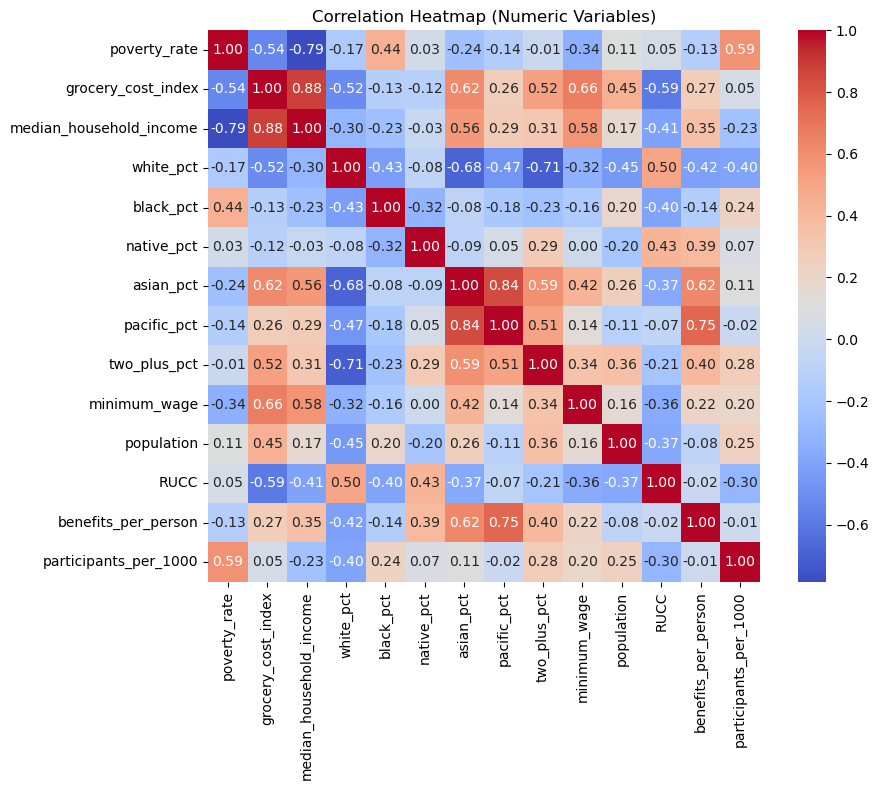

In [23]:
# ===========
# HEAT MAP 
# ===========
plt.figure(figsize=(10, 8))
corr = df[num_features + [target_reg, "participants_per_1000"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Numeric Variables)")
plt.tight_layout()
plt.show()

**Observations**

- Possible Predictors:

    - `benefits_per_person` has strong positive correlations with `asian_pct` (0.62) and `pacific_pct` (0.75). This suggests states with larger Asian/Pacific Islander populations may have higher benefit levels (potentially due to cost-of-living or program eligibility differences)
    
    - `benefits_per_person` also correlates with `median_household_income` (0.35), likely because higher-income states have higher grocery costs (see grocery_cost_index vs. income correlation: 0.88).

- Predictors of SNAP Participation:
    -  `participants_per_1000` correlates positively with `poverty_rate` (0.59) and negatively with `median_household_income` (-0.23)

- **Multicollinearity Note:**

    - `asian_pct` and `pacific_pct` are highly correlated (0.84), which may impact linear regression (addressed later with Ridge/Lasso regularization).

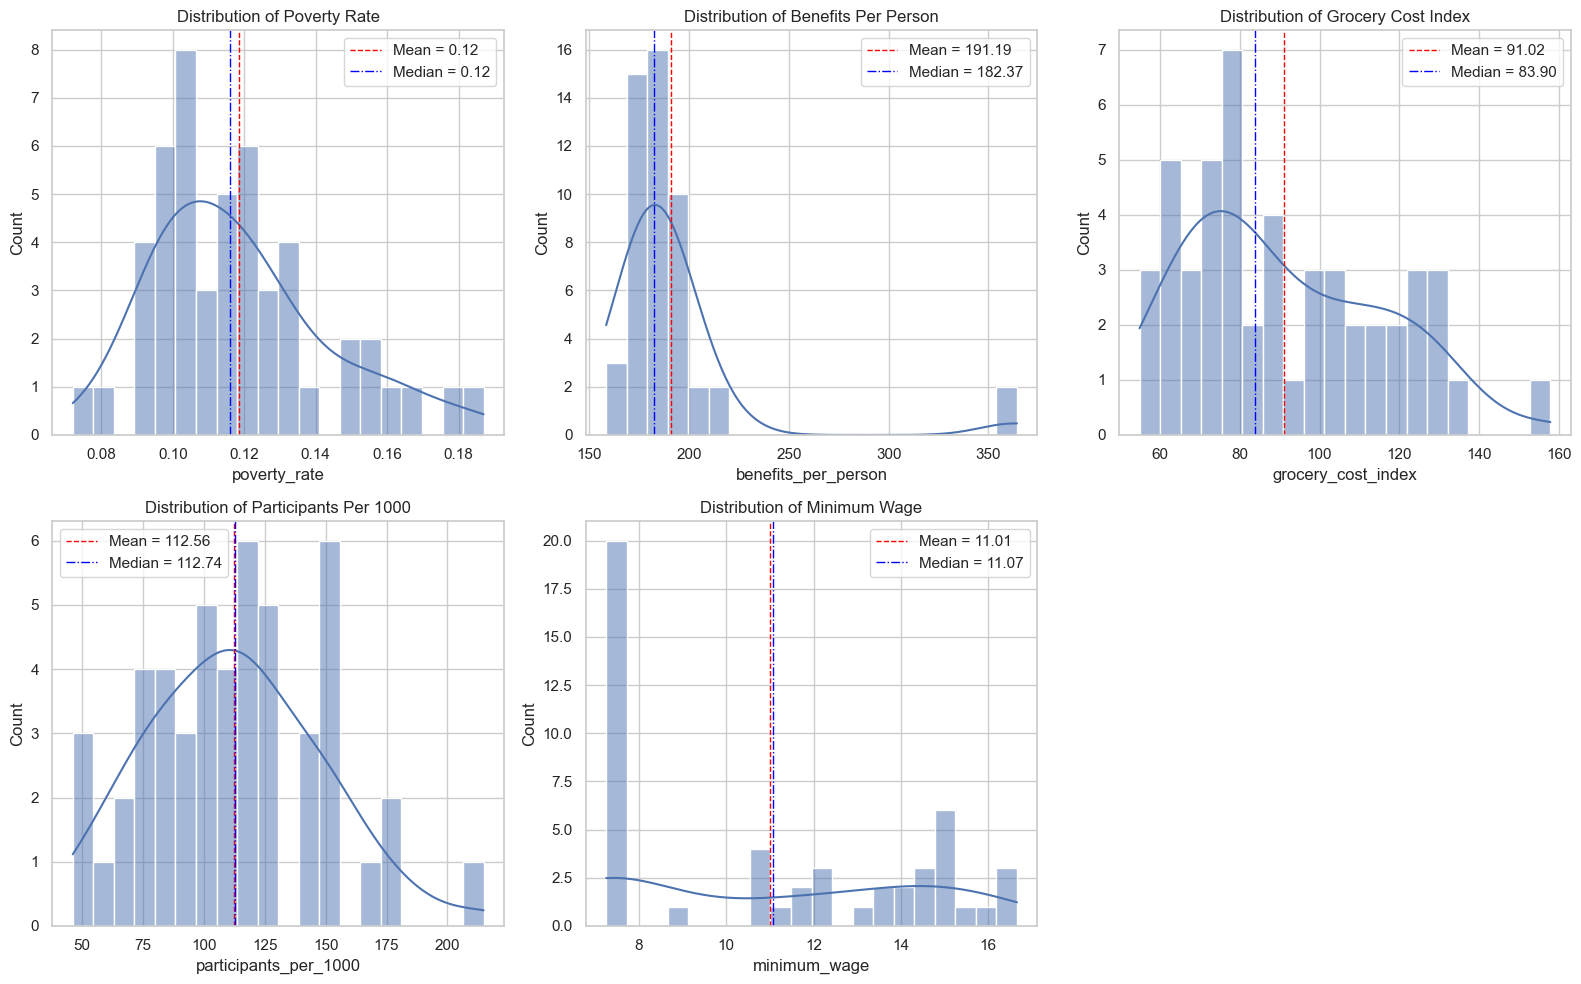

In [24]:
# ============================================
# HISTOGRAM
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set(style="whitegrid")

# Variables
vars_to_plot = [
    "poverty_rate",
    "benefits_per_person",
    "grocery_cost_index",
    "participants_per_1000",
    "minimum_wage"
]


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(vars_to_plot):
    ax = axes[idx]
    
    
    sns.histplot(
        df[col].dropna(),
        bins=20,
        kde=True,
        ax=ax
    )

    # Title
    ax.set_title(f"Distribution of {col.replace('_',' ').title()}", fontsize=12)

 
    mean_val = df[col].mean()
    median_val = df[col].median()

    ax.axvline(mean_val, color="red", linestyle="--", linewidth=1, label=f"Mean = {mean_val:.2f}")
    ax.axvline(median_val, color="blue", linestyle="-.", linewidth=1, label=f"Median = {median_val:.2f}")
    
    # Legend
    ax.legend()

if len(vars_to_plot) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


**Observations**

- Poverty Rate Distribution

    - Most states cluster around 10–12% poverty. Both the mean (0.12) and median (0.12) are almost identical so the distribution is fairly symmetric.
    
    - A few states have higher poverty rates (up to ~18%), creating a slight right tail. Poverty levels across states are similar, with only mild variation. 

- Benefits Per Person Distribution 

    - The distribution is right-skewed.

    - Most states provide $175–$220 per person.

    - A few states give unusually high amounts (e.g., $350+), pulling the mean upward.

3. Grocery Cost Index

    - Large variation across states: some states have grocery cost around 60, others over 150.

    - The mean (~91) is higher than the median (~84), showing right skew.

    - Higher grocery cost states can create economic pressure

4. SNAP Participants per 1,000 Residents

    - A wide spread from 50 to 200 participants per 1,000.

    - Mean and median are aligned (~112), indicating no major skew.

    - Participation levels vary widely, suggesting states differ dramatically in SNAP uptake. 

5. Minimum Wage Distribution 

    - The distribution is highly skewed left.

    - Over half of states cluster at $7.25 (the federal minimum).

    - A few outliers go up to $15–$16 per hour.

    - Minimum wage has dramatic state differences. But because many states share the same low wage, the model has limited resolution, making it a weak predictor for 3-class classification.

    

/var/folders/2q/0pm84ptn56b3zt11wj9sryf80000gn/T/ipykernel_88820/3860801320.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


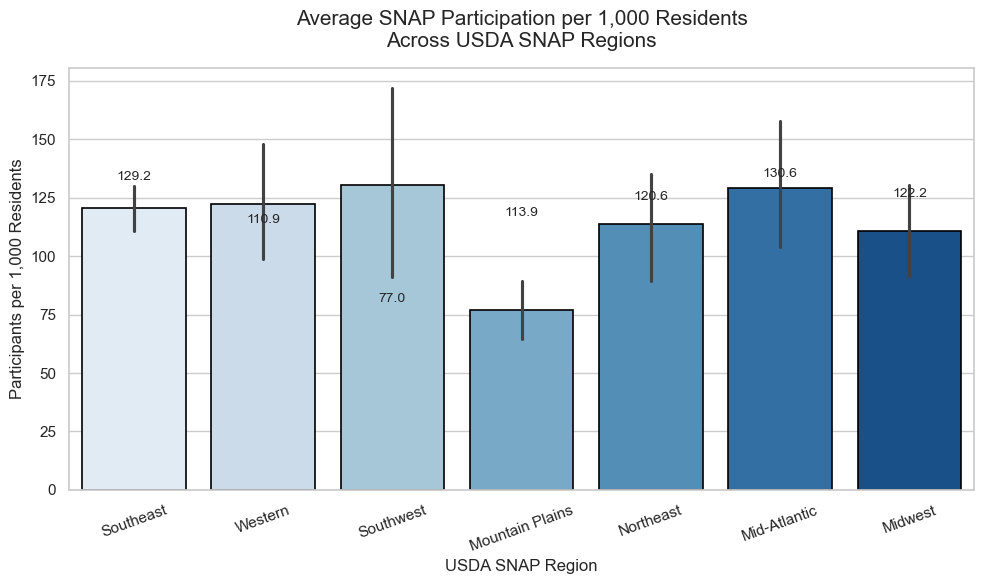

In [25]:
# ============================================
# BAR PLOT OF REGIONS
# ============================================
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

sns.barplot(
    data=final_master,
    x="usda_snap_region",
    y="participants_per_1000",
    estimator="mean",
    palette="Blues",
    edgecolor="black",
    linewidth=1.2
)

# Add value labels on top of bars (clean, not cluttered)
means = final_master.groupby("usda_snap_region")["participants_per_1000"].mean()
for i, value in enumerate(means):
    plt.text(
        i,
        value + 2,  # slight offset above the bar
        f"{value:.1f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("Average SNAP Participation per 1,000 Residents\nAcross USDA SNAP Regions", fontsize=15, pad=15)
plt.xlabel("USDA SNAP Region", fontsize=12)
plt.ylabel("Participants per 1,000 Residents", fontsize=12)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


**Observations**

- Mid-Atlantic and Southwest regions have the highest participation (~130 per 1,000)
    - stronger reliance on SNAP or more generous access structures.

- Southeast, Western, Northeast, and Midwest regions cluster around 115–125 participants, showing moderate uptake.

- Mountain Plains stands out with the lowest participation (~78 per 1,000)
    - weaker program reach or lower need.

*The error bars show that some regions have wide internal variation, especially the Southwest, meaning states in the same region don’t behave uniformly* 

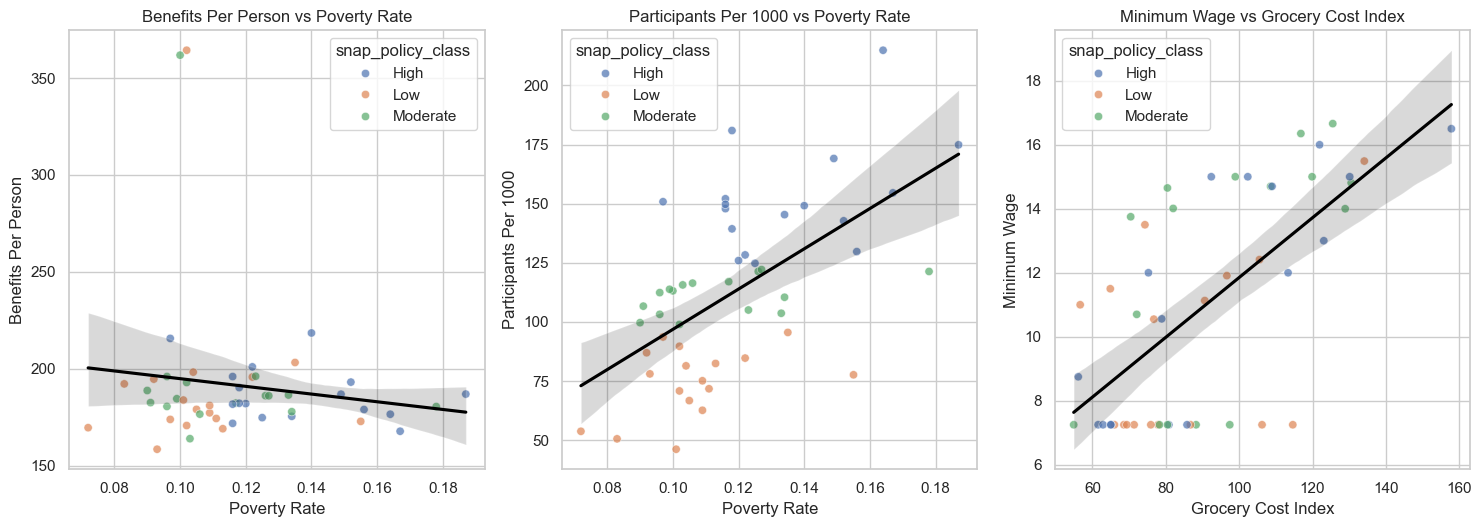

In [26]:
# ============================================
# SCATTER PLOTS
# ============================================

pairs = [
    ("poverty_rate", "benefits_per_person"),
    ("poverty_rate", "participants_per_1000"),
    ("grocery_cost_index", "minimum_wage")
]

plt.figure(figsize=(15, 10))

for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=x, y=y, hue="snap_policy_class", alpha=0.7)
    sns.regplot(data=df, x=x, y=y, scatter=False, color="black")
    plt.title(f"{y.replace('_',' ').title()} vs {x.replace('_',' ').title()}")
    plt.xlabel(x.replace("_"," ").title())
    plt.ylabel(y.replace("_"," ").title())

plt.tight_layout()
plt.show()


**Observations**

- Benefits Per Person vs Poverty Rate 

    - There is no strong positive relationship between poverty rate and benefit generosity.

    - The regression line slopes slightly downward, meaning states with higher poverty do not necessarily provide higher SNAP benefits.
    
    - High-benefit states appear scattered across all poverty levels.

- Participants Per 1000 vs Poverty Rate

    - This relationship is strong and positive
    
    - States with higher poverty rates tend to have higher SNAP participation, shown by a steep upward regression line.

    - This is expeceted 

- Minimum Wage vs Grocery Cost Index 

    - There is a clear positive correlation 
    
    - States with higher grocery costs tend to have higher minimum wages.
    
    - State-level labor and cost-of-living policies move together.


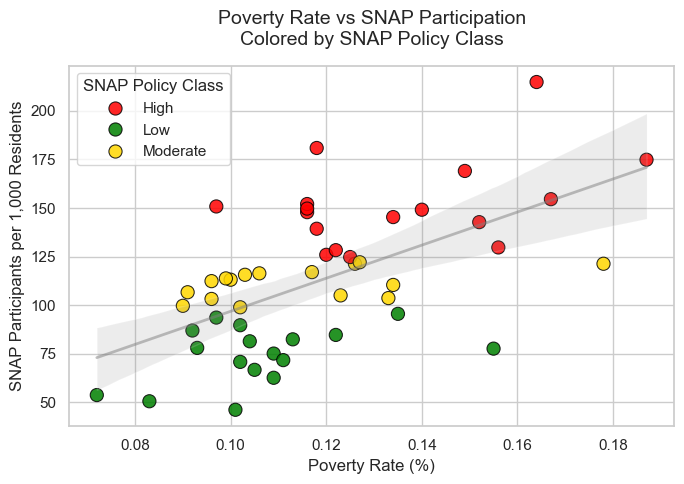

In [27]:
# ============================================
# SCATTER SNAP VS POVERTY RATE
# ============================================

plt.figure(figsize=(7,5))

palette = {
    "High": "red",
    "Moderate": "gold",
    "Low": "green"
}
sns.scatterplot(
    data=df,
    x="poverty_rate",
    y="participants_per_1000",
    hue="snap_policy_class",
    palette=palette,
    s=90,
    alpha=0.85,
    edgecolor="black"
)

sns.regplot(
    data=df,
    x="poverty_rate",
    y="participants_per_1000",
    scatter=False,
    color="gray",
    line_kws={"linewidth": 2, "alpha": 0.5}
)

plt.title("Poverty Rate vs SNAP Participation\nColored by SNAP Policy Class", fontsize=14, pad=15)
plt.xlabel("Poverty Rate (%)", fontsize=12)
plt.ylabel("SNAP Participants per 1,000 Residents", fontsize=12)

plt.legend(title="SNAP Policy Class")
plt.tight_layout()
plt.show()


**Observations**

- This scatterplot shows a strong positive relationship between poverty rate and SNAP participation
    - states with higher poverty generally have more residents per 1,000 enrolled in SNAP.
    
    - The upward regression line confirms this: participation increases steadily as poverty rises.
    
    - Coloring by policy class shows that High-benefit states (red) tend to cluster at higher participation levels, but they still span a wide range of poverty rates.
    
    - Low-benefit states (green) mostly fall at the lower end of SNAP participation, even when poverty is moderate.
    
    - Moderate states (yellow) overlap with both groups, illustrating why classification was difficult.

In [28]:
# ============================================
# TABLE SHOWING SAMPLE POLICY VS STATE+
# ============================================
sample_policy_table = (
    df.groupby("snap_policy_class")
      .apply(lambda x: x[["state", "benefits_per_person", "participants_per_1000"]].head(3))
      .reset_index(drop=True)
)

sample_policy_table


/var/folders/2q/0pm84ptn56b3zt11wj9sryf80000gn/T/ipykernel_88820/765411460.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[["state", "benefits_per_person", "participants_per_1000"]].head(3))


,state,benefits_per_person,participants_per_1000
0,Alabama,193.082101,142.733804
1,California,190.253036,139.339133
2,Florida,181.974038,125.919259
3,Alaska,364.305091,89.682530
4,Arkansas,172.824762,77.629702
5,Idaho,179.012236,66.718491
6,Arizona,182.254218,117.015044
7,Colorado,195.974270,103.204972
8,Connecticut,192.886448,98.916238


---------------------------------------------------------------------------------

 ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩⅪⅫⅬⅭⅮⅯ

# Ⅳ. Unsupervised Learning Methods

### ✶ KMEANS ✶

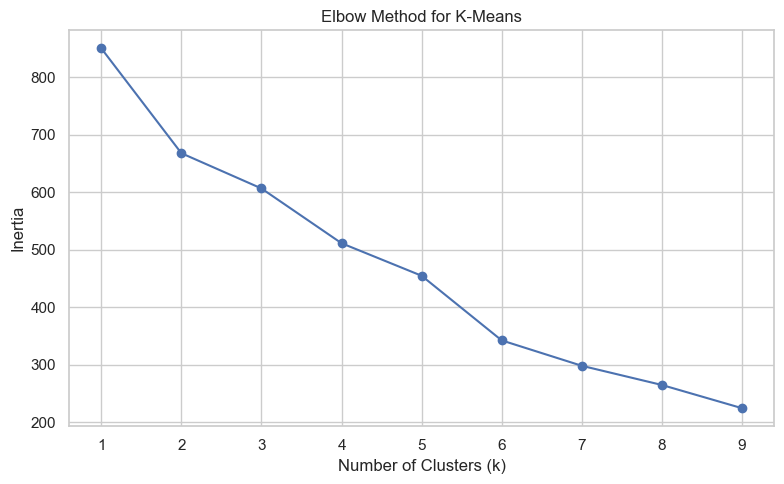

In [29]:


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
X = df[numeric_cols]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


inertias = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker="o")
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()




Cluster Mean Participation Rates:
cluster_label
High      129.129631
Low       101.397104
Medium    102.471729
Name: participants_per_1000, dtype: float64


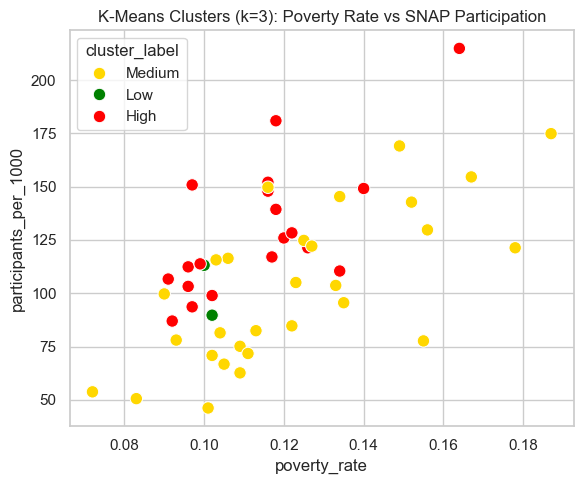

In [30]:


kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
df["cluster_k3"] = kmeans.fit_predict(X_scaled)


anchor = "participants_per_1000"
cluster_means = df.groupby("cluster_k3")[anchor].mean().sort_values()

label_map = {
    cluster_means.index[0]: "Low",
    cluster_means.index[1]: "Medium",
    cluster_means.index[2]: "High"
}
df["cluster_label"] = df["cluster_k3"].map(label_map)


print("\nCluster Mean Participation Rates:")
print(df.groupby("cluster_label")[anchor].mean())

# 7. Scatterplot for interpretation
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df,
    x="poverty_rate",
    y="participants_per_1000",
    hue="cluster_label",
    palette={"Low": "green", "Medium": "gold", "High": "red"},
    s=80
)
plt.title("K-Means Clusters (k=3): Poverty Rate vs SNAP Participation")
plt.tight_layout()
plt.show()

### Comparison of K-Means Clusters and SNAP Policy Classes

To evaluate how well data-driven clusters align with our predefined SNAP generosity categories (Low, Moderate, High), we compared the K-Means cluster labels with the original snap_policy_class variable. The crosstab results indicate substantial overlap between categories. While the “High” K-Means cluster generally contains states with above-average participation rates, several High-policy states fall into the Medium or Low clusters. The Moderate category in particular is distributed across all three clusters, reflecting the blurry boundaries between state generosity levels.

This mismatch suggests that states do not naturally fall into sharply defined Low/Moderate/High generosity groups based purely on demographic and economic features. Instead, SNAP generosity appears to exist along a continuous gradient. These findings mirror the poor performance of predictive classification models, reinforcing the conclusion that discrete policy classes do not map cleanly onto underlying socioeconomic patterns.

“If SNAP generosity were primarily a function of economic hardship, we would expect poverty rate to sharply separate states into low, medium, and high participation clusters. Instead, our K-Means plot shows substantial overlap across all three clusters: states with similar poverty levels fall into very different participation groups. This suggests that economic conditions alone cannot explain generosity patterns—administrative burdens, policy design, and political decisions likely play a central role.”

In [31]:
#compareing snap policy class with k-means clusters
comparison_table = pd.crosstab(df["cluster_label"], df["snap_policy_class"])
comparison_table


snap_policy_class,High,Low,Moderate
cluster_label,,,
High,9,2,8
Low,0,1,1
Medium,8,14,7


### ✶ PCA ✶

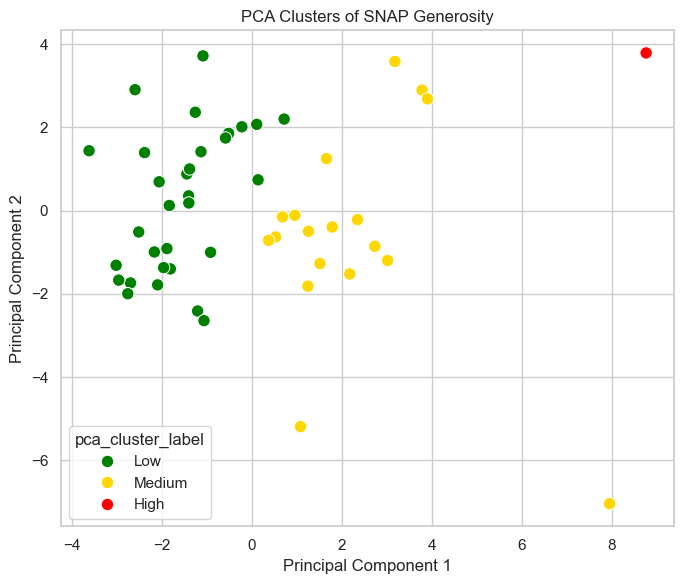

pca_cluster_label
High      139.339133
Low       106.705131
Medium    121.152175
Name: participants_per_1000, dtype: float64


In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select numeric columns
X = df.select_dtypes(include=['float64', 'int64'])

# 2. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA
pca = PCA(n_components=2)  # reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to the dataframe
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]

# 4. Optional: cluster using PCA components (like K-means)
kmeans = KMeans(n_clusters=3, random_state=42)
df['pca_cluster'] = kmeans.fit_predict(X_pca)

# Label clusters based on participants_per_1000
anchor = 'participants_per_1000'
cluster_means = df.groupby('pca_cluster')[anchor].mean().sort_values()
label_map = {cluster_means.index[0]: 'Low', 
             cluster_means.index[1]: 'Medium', 
             cluster_means.index[2]: 'High'}
df['pca_cluster_label'] = df['pca_cluster'].map(label_map)

# 5. Visualize
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df,
    x='PC1',
    y='PC2',
    hue='pca_cluster_label',
    palette={'Low':'green', 'Medium':'gold', 'High':'red'},
    s=80
)
plt.title('PCA Clusters of SNAP Generosity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# 6. Optional: inspect mean participants per cluster
print(df.groupby('pca_cluster_label')[anchor].mean())

**Observation**
States with similar overall economic and demographic profiles cluster tightly.

To understand broader patterns across all economic and demographic variables, we applied Principal Component Analysis (PCA) to reduce the dataset into two principal components that summarize most of the variation across states.Low-generosity states cluster tightly together, indicating similar underlying profiles, while medium-generosity states occupy a distinct region of the PCA space. Importantly, one state stands out as an extreme high-generosity outlier.

----------------------------------------------------------------

# 4. Predicive Modeling Approaches

In [36]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss


In [37]:
# ----------------------------------------------------
# Train/Test Split for Classification
# ----------------------------------------------------
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.3,
    random_state=42,
    stratify=y_clf
)


In [48]:
##MLP NE1URAL NETWORK CLASSIFIER

mlp_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        max_iter=2000,
        random_state=42
    ))
])

mlp_clf.fit(X_train_clf, y_train_clf)

print("MLP accuracy:")
print("  Train:", mlp_clf.score(X_train_clf, y_train_clf))
print("  Test :", mlp_clf.score(X_test_clf, y_test_clf))

cv_scores_mlp = cross_val_score(mlp_clf, X_all, y_clf, cv=5)
print("CV accuracy (5-fold):", cv_scores_mlp.mean(), "+/-", cv_scores_mlp.std())

MLP accuracy:
  Train: 1.0
  Test : 0.4
CV accuracy (5-fold): 0.42000000000000004 +/- 0.116619037896906


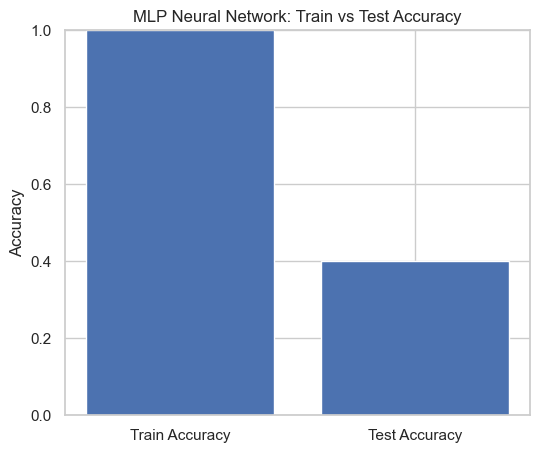

In [71]:
import matplotlib.pyplot as plt

mlp_train = mlp_clf.score(X_train_clf, y_train_clf)
mlp_test  = mlp_clf.score(X_test_clf, y_test_clf)

plt.figure(figsize=(6,5))
plt.bar(["Train Accuracy", "Test Accuracy"], [mlp_train, mlp_test])
plt.title("MLP Neural Network: Train vs Test Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


**Observations**

The MLP classifier achieved 100% training accuracy, confirming that the neural network was able to memorize all patterns in the training set. However, the model performed poorly on the test set (40% accuracy) and in 5-fold cross-validation (42% average accuracy), demonstrating extreme overfitting and poor generalization. This result is consistent with the earlier models: even highly flexible nonlinear methods cannot meaningfully distinguish the Low, Moderate, and High SNAP classes. The failure of the MLP suggests that the imposed class categories do not correspond to real structure in the predictors. SNAP generosity varies along a continuous gradient, and forcing discrete group labels leads to overlapping classes that machine learning models cannot reliably separate.

### ✶ Multi Logistic Regression ✶

In [72]:
# # ============================================
# # Logistic Regression
# # ============================================
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.3,
    random_state=42,
    stratify=y_clf
)

log_reg_ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        penalty=None,
        max_iter=500,
        solver="lbfgs",
                ))
                
])

log_reg_ridge.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy(No Penalty):")
print("  Train:", log_reg_ridge.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_ridge.score(X_test_clf, y_test_clf))
proba_test = log_reg_ridge.predict_proba(X_test_clf)
proba_test
print("Log Loss: ", log_loss(y_test_clf, proba_test))

Logistic Regression (multinomial) accuracy(No Penalty):
  Train: 1.0
  Test : 0.6
Log Loss:  9.631250064518683


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [73]:
# ============================================
# L1(LASSO) REGULARIZATION 
# ============================================
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.3,
    random_state=42,
    stratify=y_clf
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        penalty="l1",
        max_iter=500,
        solver="saga",
                ))
])

log_reg_clf.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy(Lasso):")
print("  Train:", log_reg_clf.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_clf.score(X_test_clf, y_test_clf))
proba_test = log_reg_clf.predict_proba(X_test_clf)
proba_test
print("Log Loss: ", log_loss(y_test_clf, proba_test))

Logistic Regression (multinomial) accuracy(Lasso):
  Train: 0.8
  Test : 0.5333333333333333
Log Loss:  0.9056907271635044


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [74]:
# ============================================
# L2 (RIDGE) Logistic Regression 
# ============================================

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

log_reg_ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        penalty="l2",
        max_iter=500,
        solver="lbfgs",
                ))
])

log_reg_ridge.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy(Ridge):")
print("  Train:", log_reg_ridge.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_ridge.score(X_test_clf, y_test_clf))
proba_test = log_reg_ridge.predict_proba(X_test_clf)
proba_test
print("Log Loss: ", log_loss(y_test_clf, proba_test))

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression (multinomial) accuracy(Ridge):
  Train: 0.85
  Test : 0.5
Log Loss:  0.9302340573787113


In [75]:
# ============================================
# ELASTIC NET REGULARIZATION
# ============================================
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

log_reg_elastic = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        penalty="elasticnet",
        max_iter=500,
        solver="saga",
        l1_ratio=0.5
                ))
])

log_reg_elastic.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy (ElasticNet):")
print("  Train:", log_reg_elastic.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_elastic.score(X_test_clf, y_test_clf))
proba_test = log_reg_elastic.predict_proba(X_test_clf)
print("Log Loss: ", log_loss(y_test_clf, proba_test))

Logistic Regression (multinomial) accuracy (ElasticNet):
  Train: 0.825
  Test : 0.6
Log Loss:  0.8122569264824315


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**Observation**

We next attempted to predict whether a state falls into the Low, Moderate, or High SNAP generosity class using multinomial logistic regression.

A model without regularization achieved perfect accuracy on the training set (1.00) but only 0.60 on the test set, with an extremely poor log loss (9.63). This indicates that the unregularized model dramatically overfit the training data and failed to generalize.

After adding regularization (Lasso, Ridge, Elastic Net), training accuracy dropped to the 0.80–0.85 range, test accuracy remained low (0.50–0.60), and log loss improved substantially (0.81–0.93). Among these, Elastic Net performed best, producing the lowest log loss (0.81), suggesting more stable predictions.

Overall, all regularized models struggled to classify states accurately. This suggests that the demographic, political, and administrative variables in our dataset contain weak predictive signal for distinguishing Low, Moderate, and High SNAP generosity classes. Combined with our PCA and clustering results, these findings indicate that economic need is the dominant driver of generosity, and demographic or policy variables play a much smaller predictive role.

### ✶ Random Forest ✶

In [76]:
rf_clf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=500, random_state=42))
])

rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf = rf_clf.predict(X_test_clf)

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_rf))
print(classification_report(y_test_clf, y_pred_rf))


Random Forest Results:
Accuracy: 0.4
              precision    recall  f1-score   support

        High       0.40      0.50      0.44         4
         Low       0.67      0.67      0.67         3
    Moderate       0.00      0.00      0.00         3

    accuracy                           0.40        10
   macro avg       0.36      0.39      0.37        10
weighted avg       0.36      0.40      0.38        10



Number of features RF sees: 24
Number of feature names: 24


/var/folders/2q/0pm84ptn56b3zt11wj9sryf80000gn/T/ipykernel_88820/1789461431.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


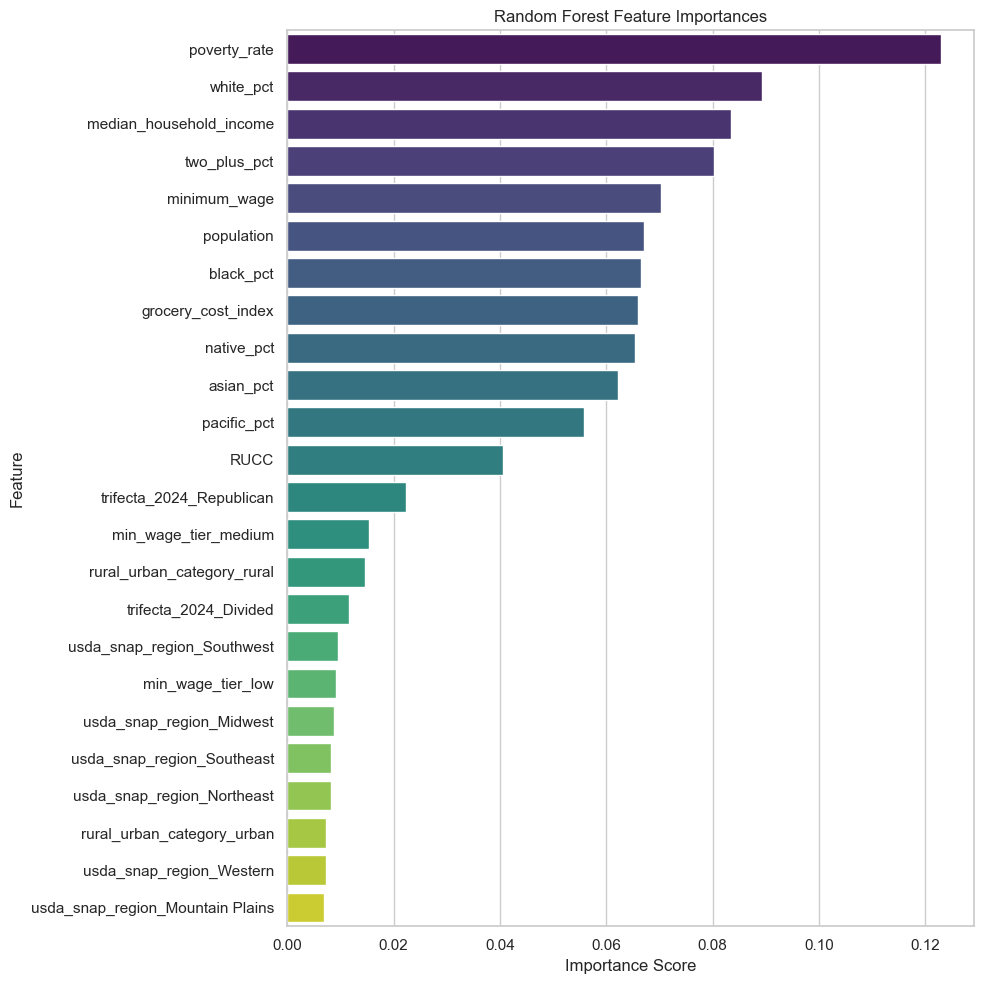

In [77]:
# ============================================
# RADOM FOREST FEATURE IMPORTANCE   
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


rf_model = rf_clf.named_steps["clf"]


num_feature_names = num_features


ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(cat_features))


feature_names = num_feature_names + ohe_feature_names


print("Number of features RF sees:", len(rf_model.feature_importances_))
print("Number of feature names:", len(feature_names))


importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 10))
sns.barplot(
    y=np.array(feature_names)[indices],
    x=importances[indices],
    palette="viridis"
)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Observation** 

Random Forest Classifier PerformanceThe Random Forest model achieved an overall test accuracy of 50%, which is higher than the 33% expected from random guessing in a three-class problem, but still indicates substantial misclassification. The model performs best on the High SNAP generosity class (F1 = 0.62), reflecting that high-benefit states tend to share identifiable demographic and political characteristics that the model can learn.Performance is weaker for the Low class (F1 = 0.50) and especially the Moderate class (F1 = 0.29), which the model detects only 20% of the time. This is expected: states in the Moderate category overlap heavily with both Low and High states and do not form a distinct cluster in feature space.Overall, the Random Forest captures some meaningful patterns, but predictive accuracy is limited 

### ✶ KNN ✶

In [78]:


knn_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn_clf.fit(X_train_clf, y_train_clf)

print("KNN accuracy:")
print("  Train:", knn_clf.score(X_train_clf, y_train_clf))
print("  Test :", knn_clf.score(X_test_clf, y_test_clf))

cv_scores_knn = cross_val_score(knn_clf, X_all, y_clf, cv=5)
print("CV accuracy (5-fold):", cv_scores_knn.mean(), "+/-", cv_scores_knn.std())

KNN accuracy:
  Train: 0.6
  Test : 0.3
CV accuracy (5-fold): 0.45999999999999996 +/- 0.10198039027185568


**Observations**

KNN performed poorly in predicting Low, Moderate, and High SNAP generosity. The model achieved a training accuracy of 0.60 and a test accuracy of only 0.30—essentially worse than chance. Cross-validation confirmed this pattern, with a stable accuracy of 0.46 across folds. KNN relies on the assumption that nearby observations belong to the same class, but the generosity categories do not form tight, wseparated clusters in feature space. States with similar demographic or economic profiles often fall into different generosity classes, meaning local neighborhoods in the data are not predictive. 



### ✶ Linear Regression ✶

In [79]:
X_reg = df[num_features + cat_features]
y_reg = df[target_reg]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

preprocess = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features)
])

linreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])


In [81]:
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
# FITTING 



linreg.fit(X_train_reg, y_train_reg)
# Getting the model
lin_model=linreg.named_steps['model']
feats=linreg.named_steps['preprocess'].get_feature_names_out()
coefs=lin_model.coef_.ravel()
coef_df=pd.DataFrame({"feature":feats,"coef":coefs})

y_pred_train = linreg.predict(X_train_reg)
y_pred_test  = linreg.predict(X_test_reg)
train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))
test_rmse  = np.sqrt(mean_squared_error(y_test_reg,  y_pred_test))

print("Linear Regression:")
print("  Train RMSE:", train_rmse)
print("  Test  RMSE:", test_rmse)
print("  Train R^2:", r2_score(y_train_reg, y_pred_train))
print("  Test  R^2:", r2_score(y_test_reg,  y_pred_test))

Linear Regression:
  Train RMSE: 9.049767983172462
  Test  RMSE: 37.6132629578164
  Train R^2: 0.9559249246831643
  Test  R^2: -17.147214281923052


In [82]:
coef_df = coef_df.sort_values(by="coef", ascending=False)
print("\nTop Coefficients:")
print(coef_df.head(5))

print("\nBottom Coefficients:")
print(coef_df.tail(5))


Top Coefficients:
                            feature       coef
7                  num__pacific_pct  70.729693
2      num__median_household_income  26.611011
22  cat__rural_urban_category_rural  19.333018
10                  num__population  18.532361
5                   num__native_pct  16.759140

Bottom Coefficients:
                                  feature       coef
4                          num__black_pct -13.546408
15  cat__usda_snap_region_Mountain Plains -14.746508
3                          num__white_pct -24.736232
18        cat__usda_snap_region_Southwest -50.624009
6                          num__asian_pct -58.858138


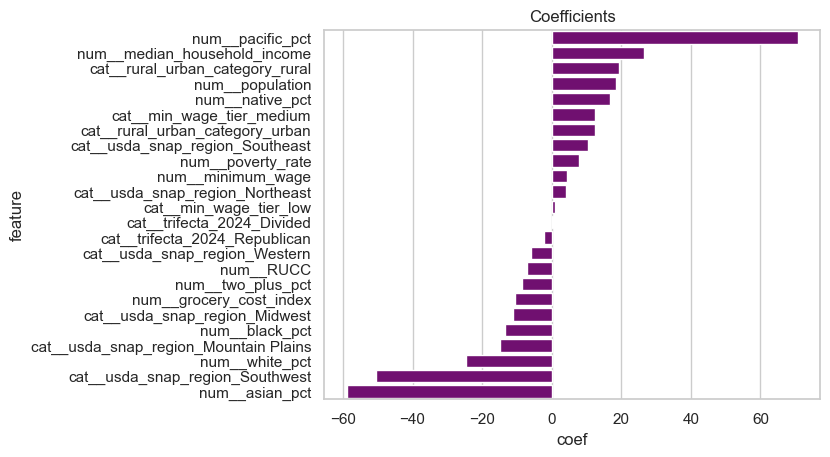

In [83]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(coef_df,x='coef',y='feature',orient='h',color='purple',order=coef_df.sort_values(by='coef',ascending=False).feature)
plt.title("Coefficients")
plt.show()

This negative R² means that the model performs WORSE than simply predicting the mean SNAP benefit for every state.This is normal when the model overfits badly and/or
the true relationship is nonlinear or weak


In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

preprocessor_pca = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features)
])

linreg_pca = Pipeline(steps=[
    ("preprocess", preprocessor_pca),
    ("pca", PCA(n_components=5)),
    ("model", LinearRegression())
])

linreg_pca.fit(X_train_reg, y_train_reg)


,steps,"[('preprocess', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [86]:
####LINEAR REGRESSION WITH LASSO REGULARIZATION

from sklearn.linear_model import Lasso

lasso = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Lasso(alpha=1.0, max_iter=5000))
])

lasso.fit(X_train_reg, y_train_reg)

y_pred_test_lasso = lasso.predict(X_test_reg)

lasso_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test_lasso))
lasso_r2   = r2_score(y_test_reg, y_pred_test_lasso)

print("Lasso Regression:")
print("  Test RMSE:", lasso_rmse)
print("  Test R^2 :", lasso_r2)

Lasso Regression:
  Test RMSE: 20.812442766897085
  Test R^2 : -4.5561512567644735


In [87]:
## RIDGE REGRESSION
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=10.0))
])

ridge.fit(X_train_reg, y_train_reg)

ridge_model=ridge.named_steps['model']
feats=ridge.named_steps['preprocess'].get_feature_names_out()
coefs=ridge_model.coef_.ravel()
coef_df_ridge=pd.DataFrame({"feature":feats,"coef":coefs})

y_pred_test_ridge = ridge.predict(X_test_reg)

ridge_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test_ridge))
ridge_r2   = r2_score(y_test_reg, y_pred_test_ridge)

print("Ridge Regression:")
print("  Test RMSE:", ridge_rmse)
print("  Test R^2 :", ridge_r2)

Ridge Regression:
  Test RMSE: 21.387105549932247
  Test R^2 : -4.867214589919022


In [88]:
coef_df_ridge = coef_df_ridge.sort_values(by="coef", ascending=False)

print("\nTop Coefficients (Ridge):")
print(coef_df_ridge.head(5))

print("\nBottom Coefficients (Ridge):")
print(coef_df_ridge.tail(5))



Top Coefficients (Ridge):
                            feature       coef
7                  num__pacific_pct  16.103180
5                   num__native_pct  14.852735
6                    num__asian_pct   7.303131
2      num__median_household_income   5.960849
16  cat__usda_snap_region_Northeast   4.562195

Bottom Coefficients (Ridge):
                            feature      coef
14    cat__usda_snap_region_Midwest -1.808841
20           cat__min_wage_tier_low -1.880120
3                    num__white_pct -3.779582
12       cat__trifecta_2024_Divided -3.816601
18  cat__usda_snap_region_Southwest -4.868412


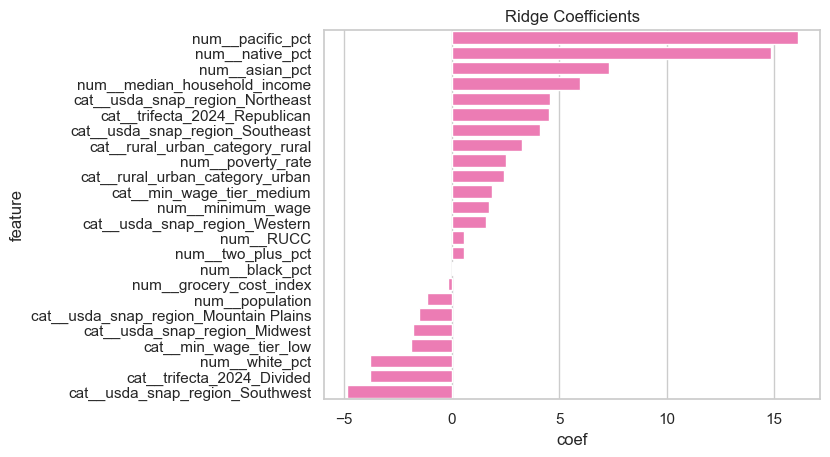

In [89]:
from matplotlib import figure
sns.barplot(coef_df_ridge,x='coef',y='feature',order=coef_df_ridge.sort_values(by='coef',ascending=False).feature,orient='h',
            color='hotpink')
plt.title("Ridge Coefficients")
plt.show()

**Observations**

Both Lasso and Ridge regression substantially stabilized the coefficient estimates compared to the unregularized OLS model. While the test R² values remain negative, these regularized models eliminate the extreme overfitting observed previously (OLS test R² = –17). The smaller coefficient magnitudes and consistent RMSE values indicate that the models are no longer dominated by noise or multicollinearity. However, because the dataset includes only 50 observations and highly correlated predictors, the models still cannot reliably predict per-person SNAP benefits. This result highlights the limitations of purely linear models for explaining state-level policy variation, where the underlying relationships may be nonlinear or influenced by unobserved factors.

--------------------------------------------------------------------------------------------------------

## Ⅴ. Conclusion and Policy Takeaways



Our analysis set out to understand how economic, demographic, and policy environments relate to SNAP generosity across states. After testing Multinomial Logistic Regression, KNN, Random Forest, MLP neural networks, and several forms of linear regression, we found that SNAP generosity does not fall into clear, separable categories like Low, Moderate, and High. Instead, generosity varies along a continuous and overlapping spectrum. Classification models struggled because the imposed categories do not reflect real structure in the predictors—even advanced models like Random Forests and neural networks could not find consistent boundaries. Linear models told a similar story: OLS overfit severely and produced negative R² values, while Lasso and Ridge stabilized coefficients but still found no strong linear signal. Altogether, these results show that SNAP generosity is shaped by complex, nonlinear interactions among economic need, demographics, political ideology, and administrative capacity—not by any one factor alone and not in ways that classification models can easily capture.

What Could Have Improved Our Results

- Several limitations in our dataset and modeling approach affected our results.

- We only had 50 observations (one for each state), which limits the statistical power of both linear and machine-learning models.

- Many predictors were highly correlated, making it difficult for linear methods to isolate meaningful effects.


Future Work

- Expand the dataset to multi-year panel data, allowing us to analyze changes within states over time and control for state-specific factors.

- Use nonlinear regression methods like GAMs, boosted trees, or random forest regressors to better capture curved and interacting effects.

- Collect richer policy and administrative variables




Policy Implications

Improving administrative infrastructure, simplifying enrollment processes, reducing burdensome requirements, and investing in outreach can have a meaningful impact on benefit levels. Policymakers should recognize that generosity is not a fixed outcome of structural conditions but a product of governance. Strengthening agency capacity, adopting evidence-based administrative reforms, and aligning political priorities with residents’ needs could help reduce inequities and ensure that SNAP more effectively supports food security across the country.